## Objectives

This notebook details the process to detect outliers in multiple time series data of electricity consumptions using the time series decomposition method.
- Input: a csv file that contains the 3 fields needed: Account (account id), Month (calendar month), Value (numerical column to detect outliers from)
- Output: an R tibble for each of the accounts and an outlier indicator column for each month's value 

## Load packages

In [1]:
library(tidyverse)
library(anomalize)
library(ggQC)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



## Read in dataset

In [5]:
# read in the csv file which contains the prorated and imputed KWH_Consumption data for NYCHA accounts
tb_all = read_csv("../../output/NYCHA_TS.csv")

# filter out unnecessary columns
tb_all = select(tb_all, c('Building_Meter', 'Month', 'Imputed_KWH'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Building_Meter = col_character(),
  Month = col_date(format = ""),
  Month_Type = col_character(),
  `Month_#_Days` = col_double(),
  Prorated_Days = col_double(),
  Gap_Days = col_double(),
  Gap_Type = col_character(),
  Prorated_KWH = col_double(),
  Imputed_KWH = col_double()
)


## Rename the columns

In [6]:
tb_all <- rename(tb_all, Account = Building_Meter, Value = Imputed_KWH)

## Focus on accounts that have more than 50 months of valid data

In [7]:
# tb <- na_if(tb, 0)

accounts = tb_all %>% group_by(Account) 

# accounts <- accounts %>% summarise(counts = n(), na_counts = sum(is.na(Imputed_KWH)))
accounts <- accounts %>% summarise(counts = n(), na_counts = sum(Value == 0))
accounts <- filter(accounts, counts - na_counts >= 50)
accounts <- mutate(accounts, na_perc = na_counts/counts)

### Define a function to calculate the deviation of a residual from the limit values

In [10]:
cal_dev <- function(residual, upper, lower) {
  if (residual < lower) {
    return(lower - residual)
  } else if (residual > upper) {
    return(residual - upper)
  } else {
    return (NA)
  }
}

## Loop through all accounts to apply STL decomposition and ourlier detection methods

In [6]:
results_stl <- vector("list", length(accounts)) 

start.time <- Sys.time()

for (i in 1:length(accounts$Account)) {
# for (i in 1:3) {
    # select the data for the input account
    ts = select(filter(tb_all, Account == accounts$Account[[i]]), 'Month', 'Value')
    
    # apply STL decomposition
    ts_anomalized <- ts %>%
        time_decompose(Value, merge = TRUE, method = 'stl')
    
    # rename and reorder the columns of the resulting dataframe
    ts_anomalized$Account = accounts$Account[[i]]
    ts_anomalized$Missing_Value = ts_anomalized$Value == 0
    ts_anomalized <- rename(ts_anomalized, Calendar_Month = Month, Total = Value, Trend = trend, Seasonal = season
       , Residual = remainder)
    ts_anomalized <- ts_anomalized[, c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')]


    # Calculate residuals
    iqr_3X <- ts_anomalized %>%
            anomalize(Residual, method = 'iqr', alpha = 0.05)

    iqr_3X <- iqr_3X[, c('Account', 'Calendar_Month', 'Residual', 'Residual_l1', 'Residual_l2', 'anomaly')]
    iqr_3X <- rename(iqr_3X, Lower = Residual_l1, Upper = Residual_l2, Anomaly = anomaly)
    iqr_3X <- mutate(iqr_3X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

    iqr_6X <- ts_anomalized %>%
            anomalize(Residual, method = 'iqr', alpha = 0.025)

    iqr_6X <- iqr_6X[, c('Account', 'Calendar_Month', 'Residual', 'Residual_l1', 'Residual_l2', 'anomaly')]
    iqr_6X <- rename(iqr_6X, Lower = Residual_l1, Upper = Residual_l2, Anomaly = anomaly)
    iqr_6X <- mutate(iqr_6X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

    ctrl_limits <- QC_Lines(data = ts_anomalized$Residual, method = "XmR")  
    ctrl_limits <- ctrl_limits[, c('xBar_one_LCL', 'xBar_one_UCL')]
    ctrl_limits <- rename(ctrl_limits, Lower= xBar_one_LCL, Upper = xBar_one_UCL)
    xmr_mean <- cbind(ts_anomalized[, c('Account', 'Calendar_Month', 'Residual')], ctrl_limits)
    
    
    # Add deviation from limit, rank of outlier and outlier indicator (for XmR only)
    iqr_3X$Dev <- mapply(cal_dev, iqr_3X$Residual, iqr_3X$Upper, iqr_3X$Lower)
    iqr_3X <- arrange(iqr_3X, desc(Dev))
    iqr_3X$Rank = seq(1:nrow(iqr_3X))
    iqr_3X[is.na(iqr_3X$Dev), ]$Rank <- NA

    iqr_6X$Dev <- mapply(cal_dev, iqr_6X$Residual, iqr_6X$Upper, iqr_6X$Lower)
    iqr_6X <- arrange(iqr_6X, desc(Dev))
    iqr_6X$Rank = seq(1:nrow(iqr_6X))
    iqr_6X[is.na(iqr_6X$Dev), ]$Rank <- NA

    xmr_mean$Dev <- mapply(cal_dev, xmr_mean$Residual, xmr_mean$Upper, xmr_mean$Lower)
    xmr_mean <- arrange(xmr_mean, desc(Dev))
    xmr_mean$Rank = seq(1:nrow(xmr_mean))
    xmr_mean[is.na(xmr_mean$Dev), ]$Rank <- NA
    xmr_mean <- mutate(xmr_mean, Anomaly = ifelse(is.na(Dev), FALSE, TRUE))
    
    
    # rename the columns
    iqr_3X <- rename(iqr_3X, Lower_3X = Lower, Upper_3X = Upper, Anomaly_3X = Anomaly, Dev_3X = Dev, Rank_3X = Rank)
    iqr_6X <- rename(iqr_6X, Lower_6X = Lower, Upper_6X = Upper, Anomaly_6X = Anomaly, Dev_6X = Dev, Rank_6X = Rank)
    xmr_mean <- rename(xmr_mean, Lower_xmr = Lower, Upper_xmr = Upper, Anomaly_xmr = Anomaly, Dev_xmr = Dev, Rank_xmr = Rank)

    
    # Combine the results of 3 methods
    result <- 
    ts_anomalized[c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')] %>% 
        inner_join(iqr_3X[, -3], by = c('Account', 'Calendar_Month')) %>%
        inner_join(iqr_6X[, -3], by = c('Account', 'Calendar_Month')) %>%
        inner_join(xmr_mean[, -3], by = c('Account', 'Calendar_Month')) 

    # considered as an outlier if 
    #     1) STL_6X outputs it as an outliers OR
    #     2) STL_6X outputs it as a normal point but both other two methods output it as an outlier
    result <- mutate(result
        , Anomaly_Voted = ifelse(((Anomaly_6X == TRUE) | ((Anomaly_6X == FALSE) & (Anomaly_xmr == TRUE & Anomaly_3X == TRUE))), TRUE, FALSE)
    )

    # weighted rank of the outlier
    results_stl[[i]] <- 
        mutate(result, Rank_Weighted = ifelse(is.na(Rank_6X), (Rank_3X + Rank_xmr)/2, Rank_6X))

}

end.time <- Sys.time()
time.taken.stl <- end.time - start.time

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months
Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


### runtime per account

In [11]:
time.taken.stl/1916

Time difference of 0.002022553 mins

## Save the result to an Rdata file

In [8]:
save(results_stl, time.taken.stl, accounts, file = "./decomposition_results.RData")

In [45]:
# load('./decomposition_results.RData')

## Check the outliers

### Find the index of a given account

In [46]:
account = '1.0 - BLD 03_7177432'
i = match(account, accounts$Account)

In [47]:
# check the outliers identified
arrange(select(filter(results_stl[[i]], Anomaly_Voted == TRUE)
       , c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual', 'Anomaly_3X'
          , 'Anomaly_6X', 'Anomaly_xmr', 'Anomaly_Voted', 'Rank_Weighted'))
       , Rank_Weighted)

Account,Calendar_Month,Missing_Value,Total,Trend,Seasonal,Residual,Anomaly_3X,Anomaly_6X,Anomaly_xmr,Anomaly_Voted,Rank_Weighted
1.0 - BLD 03_7177432,2015-08-01,TRUE,0,1143.272,38.273379,-1181.545,TRUE,FALSE,TRUE,TRUE,1
1.0 - BLD 03_7177432,2016-01-01,TRUE,0,1136.379,23.060967,-1159.440,TRUE,FALSE,TRUE,TRUE,2
1.0 - BLD 03_7177432,2016-05-01,TRUE,0,1114.632,42.231909,-1156.864,TRUE,FALSE,TRUE,TRUE,3
1.0 - BLD 03_7177432,2016-06-01,TRUE,0,1107.304,11.112308,-1118.416,TRUE,FALSE,TRUE,TRUE,4
1.0 - BLD 03_7177432,2017-10-01,TRUE,0,1040.111,63.157089,-1103.268,TRUE,FALSE,TRUE,TRUE,5
1.0 - BLD 03_7177432,2017-05-01,TRUE,0,1057.813,42.231909,-1100.045,TRUE,FALSE,TRUE,TRUE,6
1.0 - BLD 03_7177432,2017-09-01,TRUE,0,1043.660,46.946792,-1090.607,TRUE,FALSE,TRUE,TRUE,7
1.0 - BLD 03_7177432,2017-08-01,TRUE,0,1047.209,38.273379,-1085.482,TRUE,FALSE,TRUE,TRUE,8
1.0 - BLD 03_7177432,2016-03-01,TRUE,0,1129.290,-44.525545,-1084.765,TRUE,FALSE,TRUE,TRUE,9
1.0 - BLD 03_7177432,2017-07-01,TRUE,0,1050.758,28.846822,-1079.605,TRUE,FALSE,TRUE,TRUE,10


In [1]:
arrange(select(filter(results_stl[[i]], Anomaly_Voted == TRUE)
       , c('Account', 'Calendar_Month', 'Total', 'Anomaly_Voted', 'Rank_Weighted'))
       , Rank_Weighted)

ERROR: Error in arrange(select(filter(results_stl[[i]], Anomaly_Voted == TRUE), : could not find function "arrange"


## Visualize the outliers

### XmR charts

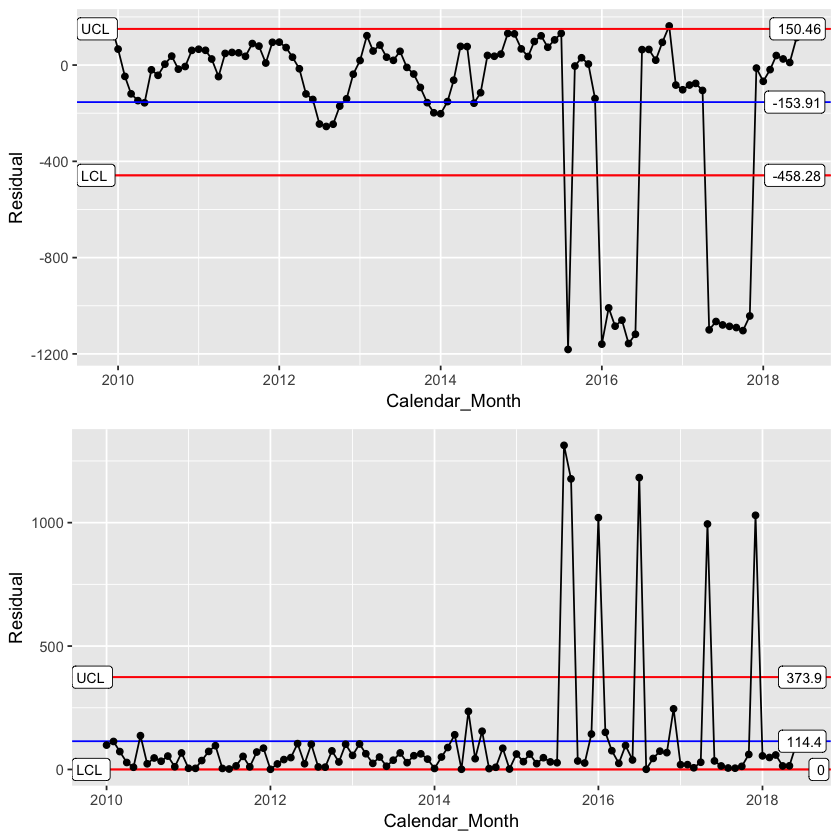

In [48]:
x_Plot <- ggplot(results_stl[[i]], aes(x = Calendar_Month, y = Residual)) + geom_point() + geom_line() + 
  stat_QC(method = 'XmR', auto.label = T, label.digits = 2, show.1n2.sigma = F) 

mR_Plot <- ggplot(results_stl[[i]], aes(x = Calendar_Month, y = Residual)) + stat_mR() + stat_QC_labels(method="mR")

grid.arrange(x_Plot, mR_Plot, nrow=2)

### IQR 3X

#### plotting configuration for the flagged anomalies

In [15]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

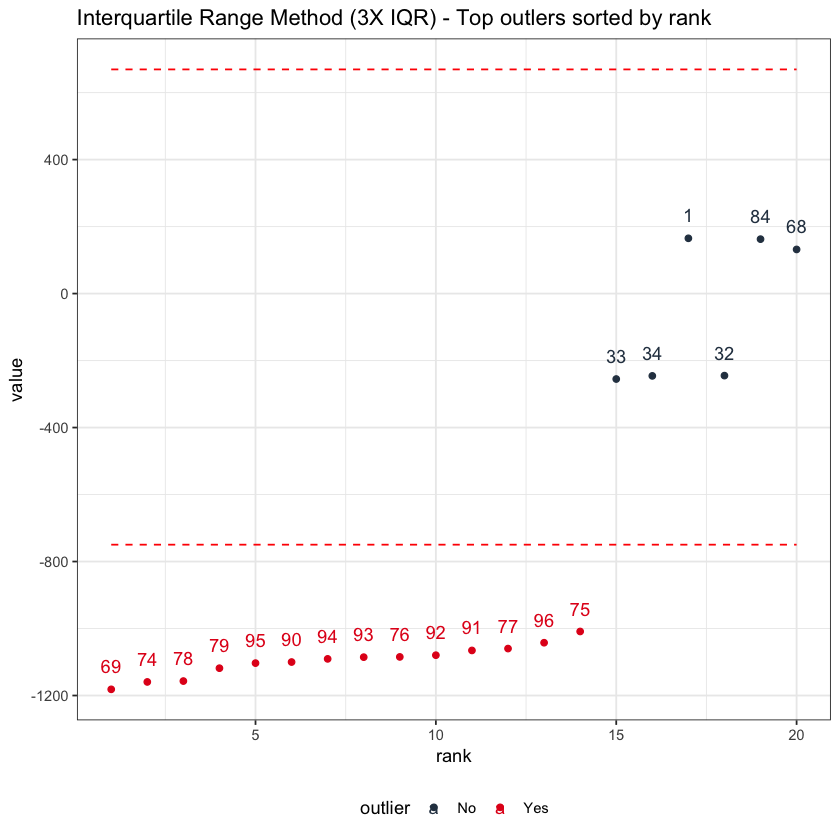

In [16]:
outliers <- iqr(results_stl[[i]]$Residual, verbose = TRUE, alpha = 0.05)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Interquartile Range Method (3X IQR) - Top outlers sorted by rank") 

### IQR 6X

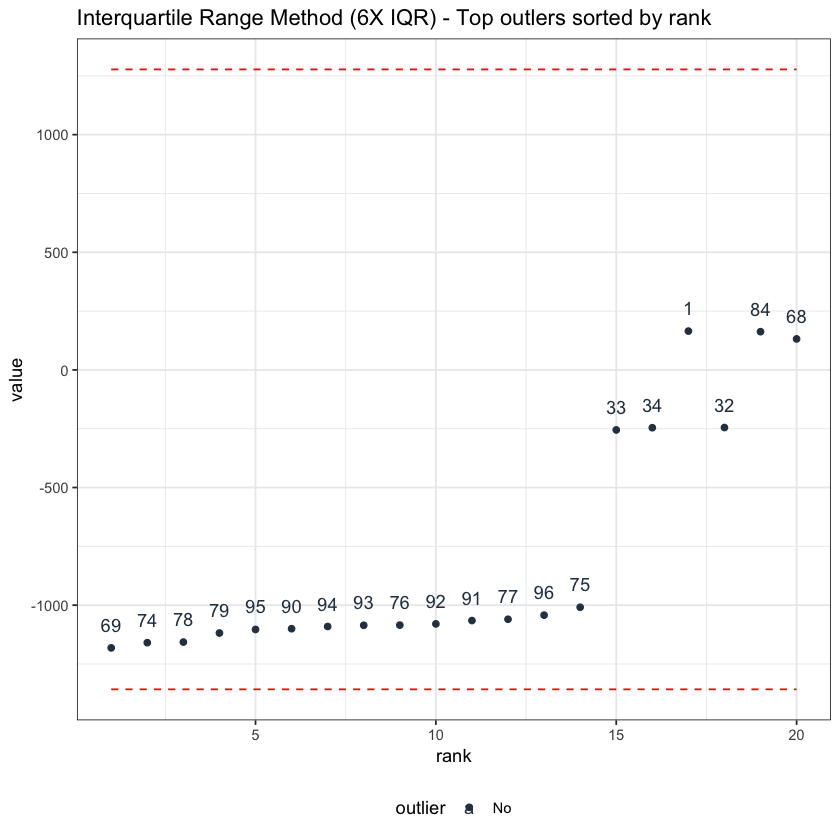

In [17]:
outliers <- iqr(results_stl[[i]]$Residual, verbose = TRUE, alpha = 0.025)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Interquartile Range Method (6X IQR) - Top outlers sorted by rank") 

## Summarize the outliers detected in all accounts

In [9]:
points = lapply(results_stl, function(i) nrow(i))
anoamly_counts = lapply(results_stl, function(i) nrow(filter(i, Anomaly_Voted == TRUE)))
na_counts = lapply(results_stl, function(i) nrow(filter(i, Missing_Value == TRUE)))
anomaly_non_na_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == TRUE) & (Missing_Value == FALSE))))
anomaly_na_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == TRUE) & (Missing_Value == TRUE))))
na_non_anomaly_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == FALSE) & (Missing_Value == TRUE))))

summary_stl = tibble('account' = accounts$Account, 'points' = unlist(points)
                     , 'na' = unlist(na_counts)
                     , 'anomalies' = unlist(anoamly_counts), 'anomalies_non_na' = unlist(anomaly_non_na_counts)
                     , 'anomalies_na' = unlist(anomaly_na_counts)
                     , 'na_non_anomaly' = unlist(na_non_anomaly_counts)
                    )

In [10]:
summary_stl <- mutate(summary_stl, na_perc = na/points)
summary_stl = mutate(summary_stl, anom_perc = anomalies_non_na /(points))
summary_stl = mutate(summary_stl, na_recall = anomalies_na /(na))
summary(summary_stl$anom_perc)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.009709 0.029703 0.034890 0.052632 0.196078 

In [11]:
head(summary_stl)

account,points,na,anomalies,anomalies_non_na,anomalies_na,na_non_anomaly,na_perc,anom_perc,na_recall
1.0 - BLD 01_7836716,103,13,19,6,13,0,0.1262136,0.05825243,1
1.0 - BLD 01_7838586,103,16,19,3,16,0,0.1553398,0.02912621,1
1.0 - BLD 02_7694040,103,13,13,0,13,0,0.1262136,0.00000000,1
1.0 - BLD 03_7177432,103,14,14,0,14,0,0.1359223,0.00000000,1
1.0 - BLD 04_7381828,103,13,16,3,13,0,0.1262136,0.02912621,1
1.0 - BLD 05_6889487,103,13,13,0,13,0,0.1262136,0.00000000,1


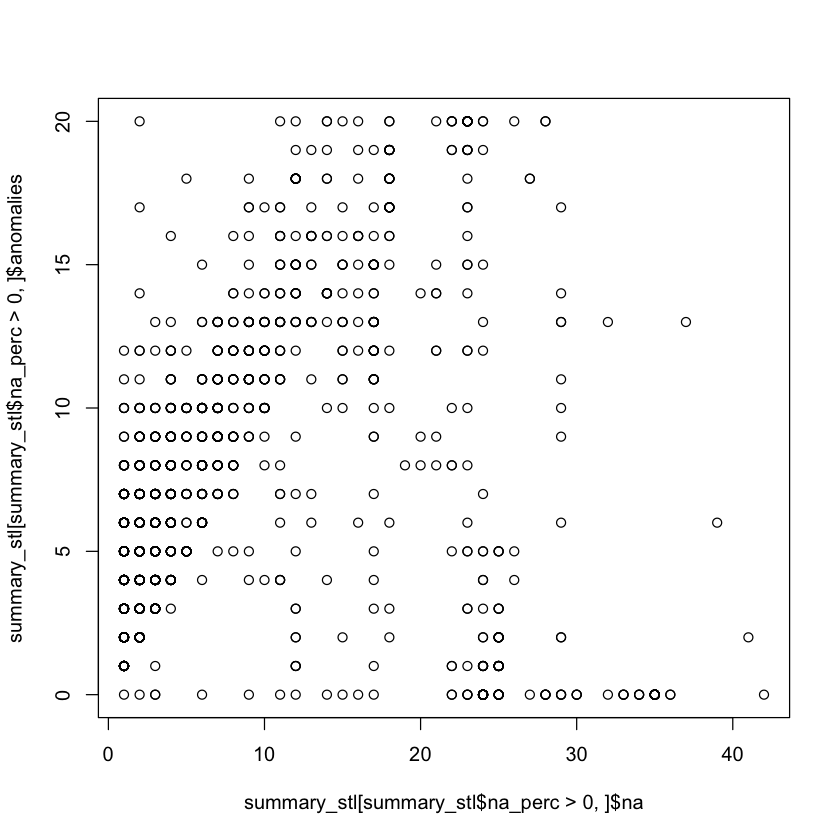

In [12]:
plot(summary_stl[summary_stl$na_perc > 0, ]$na, summary_stl[summary_stl$na_perc > 0, ]$anomalies)

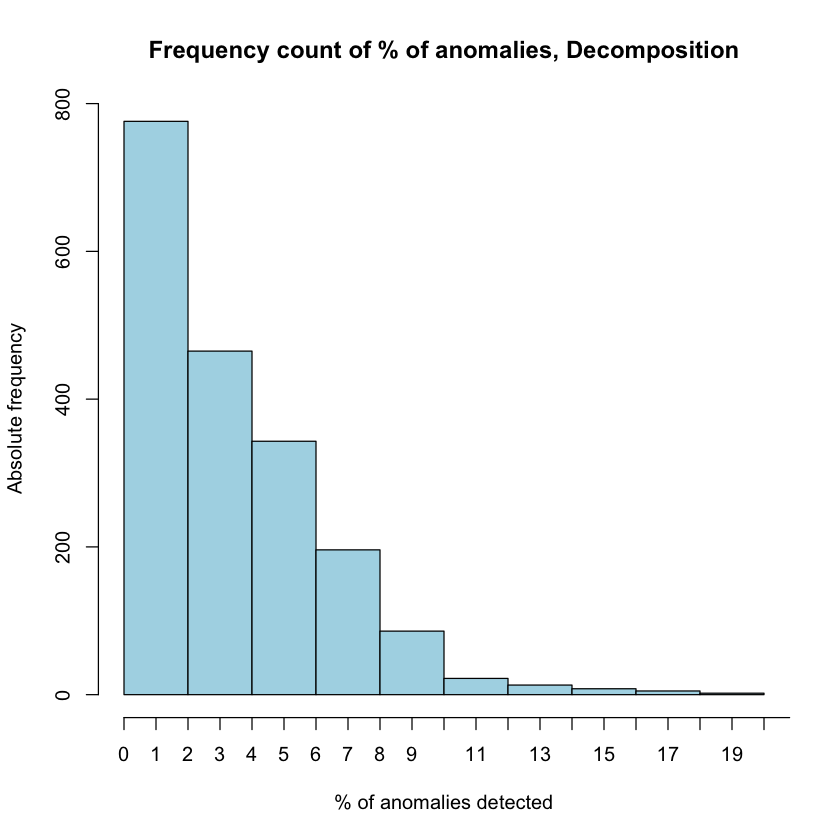

In [31]:
hist(summary_stl$anom_perc * 100,
      main="Frequency count of % of anomalies, Decomposition",
      xlab="% of anomalies detected",
      ylab="Absolute frequency",
#       breaks=100,
      col="lightblue",
      freq=TRUE,                            # freq=FALSE means to plot density, not counts
      xaxt="n")                              # xaxt="n" means "x axis tick marks == no"
axis(side=1, at=seq(0, 50, by = 1))                        

In [16]:
tmp <- select(summary_stl, c('account', 'points', 'anomalies_non_na'))

tmp <- rename(tmp, anomalies = anomalies_non_na)

In [19]:
write_csv(tmp, '../../output/summary_decomposition.csv')